rm: cannot remove 'nodes/mil/.DS_Store': No such file or directory
rm: cannot remove 'edges/.DS_Store': No such file or directory
center is two points
ditopic linker: center are two points
find connected X in edge:   3
find connected X in edge:   6


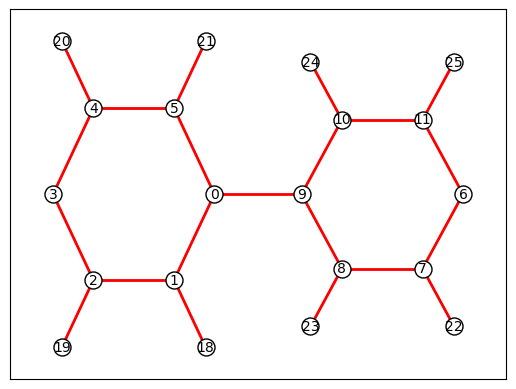

In [3]:
from MOF_builder.tritopic import MOF_tri
from frag_recognizer import process_linker_molecule
import numpy as np
import veloxchem as vlx

template = 'rna copy.cif' #UIO6x #lib file 
node_connection= 6   #lib file 
linker_topic = 2
##linker_file = 'diph.xyz'
molecule = vlx.Molecule.read_xyz_file('diph.xyz')


#######################################################################
! rm nodes/mil/.DS_Store
! rm edges/.DS_Store
#! rm edges/*.cif
process_linker_molecule(molecule,linker_topic)
templates_dir = "templates"
nodes_dir = 'nodes' #default 
edges_dir = 'edges' #default 


#new_mof = MOF_tri(templates_dir,nodes_dir,edges_dir,template,node_connection)
#new_mof.load(False)

In [3]:
supercell= np.asarray([0,0,0])
new_mof.basic_supercell(supercell,term_file = '../data/methyl.pdb')
new_mof.write_basic_supercell('mil1.gro','mil2.xyz')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
from pathlib import Path
import numpy as np
import os
import datetime
import veloxchem as vlx
import networkx as nx
import matplotlib.pyplot as plt


def create_lG(molecule):
    matrix=molecule.get_connectivity_matrix()
    coords=molecule.get_coordinates_in_angstrom()
    labels = molecule.get_labels()
    dist_matrix = molecule.get_distance_matrix_in_angstrom()
    mass_center_bohr=molecule.center_of_mass_in_bohr()
    bohr_to_angstrom = 0.529177
    mass_center_angstrom = np.asarray(mass_center_bohr)*bohr_to_angstrom 
    coords = coords - mass_center_angstrom


    METEL_ELEMENTS = ['Ac','Ag','Al','Am','Au','Ba','Be','Bi',
				  'Bk','Ca','Cd','Ce','Cf','Cm','Co','Cr',
				  'Cs','Cu','Dy','Er','Es','Eu','Fe','Fm',
				  'Ga','Gd','Hf','Hg','Ho','In','Ir',
				  'K','La','Li','Lr','Lu','Md','Mg','Mn',
				  'Mo','Na','Nb','Nd','Ni','No','Np','Os',
				  'Pa','Pb','Pd','Pm','Pr','Pt','Pu','Ra',
				  'Rb','Re','Rh','Ru','Sc','Sm','Sn','Sr',
				  'Ta','Tb','Tc','Th','Ti','Tl','Tm','U',
				  'V','W','Y','Yb','Zn','Zr']

    lG=nx.Graph()
    metals=[]
    for i in range(len(labels)):
            lG.add_nodes_from([(i,{'label': labels[i],'coords': coords[i]})])
            if labels[i] in METEL_ELEMENTS:
                metals.append(i)

    i=None
    for i in range(len(labels)):
        for j in np.where(matrix[i]==1)[0]:
            if i not in metals and j not in metals:
                lG.add_edge(i,j,weight = dist_matrix[i,j])    
    return lG,metals,mass_center_angstrom

def plot2dedge(lG,coords,cycle,EDGE_length=False):
    #pos = coords
    #nodes = np.array([pos[v] for v in lG])
    #edges = np.array([(pos[u], pos[v]) for u, v in lG.edges()])
    #pos = None
    pos = coords[:,:-1]
    # explicitly set positions
    #pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}

    options = {
            "font_size": 10,
            "node_size": 150,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }
    nx.draw_networkx(lG,pos,**options)


    # edge weight labels
    if EDGE_length:
        edge_labels = nx.get_edge_attributes(lG, "weight")
        nx.draw_networkx_edge_labels(lG, pos, edge_labels)

    # Highlight the cycle in red
    if len(cycle)>0:
        nx.draw_networkx_edges(lG, pos, edgelist=cycle, edge_color="r", width=2)
    plt.show()

def find_center_cycle_nodes(lG):
    #To find center cycle
    target_nodes = set(nx.center(lG))
    cycles=list(nx.simple_cycles(lG,length_bound=80))
    for cycle in cycles:
        if target_nodes < set(cycle):
            return cycle
        
def distinguish_G_centers(lG):
    centers = nx.center(lG)
    if len(centers)==1:
        print('center is a point')
        center_class = 'onepoint'
        center_nodes = centers
    elif len(centers)==2:
        if nx.shortest_path_length(lG,centers[0],centers[1])==1:
            print('center is two points')
            center_class = 'twopoints'
            center_nodes = centers
        else:
            print('center is a cycle')
            center_class = 'cycle'
            center_nodes = find_center_cycle_nodes(lG)
    else:
        print('center is a cycle')
        center_class = 'cycle'
        center_nodes = find_center_cycle_nodes(lG)
    return center_class,center_nodes

def classify_nodes(lG,center_nodes):
    # Step 1: Identify the center node(s) of the graph
    #center_nodes = nx.center(lG)

    for center_ind in range(len(center_nodes)):
        #to classify which node belonging to which center_node, add 'cnode_l' to lG nodes
        # Compute the shortest path length from the center node to all other nodes
        center = center_nodes[center_ind]
        lengths = nx.single_source_shortest_path_length(lG, center)
        if center_ind == 0:
            for k in lengths:
                    lG.nodes[k]['cnodes_l']=(center,lengths[k])
        elif center_ind >0:
                for k in lengths:  
                    if lengths[k] < lG.nodes[k]['cnodes_l'][1]:
                        lG.nodes[k]['cnodes_l']=(center,lengths[k])
                    elif lengths[k] == lG.nodes[k]['cnodes_l'][1]:
                        lG.nodes[k]['cnodes_l']=(-1,lengths[k]) #if the node is between any two center nodes
    return lG

def get_pairX_outer_frag(connected_pairXs,outer_frag_nodes):
    for x in list(connected_pairXs):
            pairXs = [connected_pairXs[x][1],connected_pairXs[x][3]]
            if set(pairXs) < set(outer_frag_nodes):
                break
    return pairXs

def cleave_outer_frag_subgraph(lG,pairXs,outer_frag_nodes):

    subgraph_outer_frag = lG.subgraph(outer_frag_nodes)
    kick_nodes = []
    for i in list(outer_frag_nodes):
        if nx.shortest_path_length(subgraph_outer_frag,pairXs[0],i) > nx.shortest_path_length(subgraph_outer_frag,pairXs[0],pairXs[1]):
            kick_nodes.append(i)
        elif nx.shortest_path_length(subgraph_outer_frag,pairXs[1],i) > nx.shortest_path_length(subgraph_outer_frag,pairXs[0],pairXs[1]):
            kick_nodes.append(i)
        
    subgraph_single_frag = lG.subgraph(outer_frag_nodes-set(kick_nodes))
    return subgraph_single_frag

def lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords,mass_center_angstrom):
    count = 1
    lines = []
    for cn in list(subgraph_center_frag.nodes):
        label = subgraph_center_frag.nodes[cn]['label']
        coord = subgraph_center_frag.nodes[cn]['coords']
        if cn not in Xs_indices:
            name = label+str(count)
        else:
            name = 'X'+str(count)
        count+=1
        lines.append([name,label,coord[0],coord[1],coord[2]])
    for cm in metals:
        label = labels[cm]
        coord = coords[cm]-mass_center_angstrom
        name = label+str(count)
        lines.append([name,label,coord[0],coord[1],coord[2]])
    return lines

def lines_of_single_frag(subgraph_single_frag,Xs_indices):
    count =1
    rows = []
    for sn in list(subgraph_single_frag.nodes):
        label = subgraph_single_frag.nodes[sn]['label']
        coord = subgraph_single_frag.nodes[sn]['coords']
        if sn not in Xs_indices:
            name = label+str(count)
        else:
            name = 'X'+str(count)
        count+=1
        rows.append([name,label,coord[0],coord[1],coord[2]])
    return rows

def get_atom_name_in_subgraph(subgraph,n_id,Xs_indices):
    for ind, value in enumerate(list(subgraph.nodes)):
        if value == n_id:
            if value not in Xs_indices:
                return (subgraph.nodes[n_id]['label']+ str(ind+1))
            else:
                return ('X'+ str(ind+1))
        
def get_bonds_from_subgraph(subgraph,Xs_indices):
    bonds =[]
    for e in list(subgraph.edges):
        atom1 = get_atom_name_in_subgraph(subgraph,e[0],Xs_indices)
        atom2 = get_atom_name_in_subgraph(subgraph,e[1],Xs_indices)
        length = subgraph.edges[e]['weight']/50  # 50 50 50 box
        sym = '.'
        if atom1[0]=='X' or atom2[0]=='X':
            bond_type = 'A'
        else:
            bond_type = 'S'
        bonds.append([atom1,atom2,length,sym,bond_type])

    return bonds

def create_cif(name_label_coords, bonds, foldername,cifname):
	opath = os.path.join(foldername, cifname)
	
	with open(opath, 'w') as out:
		out.write('data_' + cifname[0:-4] + '\n')
		out.write('_audit_creation_date              ' + datetime.datetime.today().strftime('%Y-%m-%d') + '\n')
		out.write("_audit_creation_method            'MOFbuilder'" + '\n')
		out.write("_symmetry_space_group_name_H-M    'P1'" + '\n')
		out.write('_symmetry_Int_Tables_number       1' + '\n')
		out.write('_symmetry_cell_setting            triclinic' + '\n')
		out.write('loop_' + '\n')
		out.write('_symmetry_equiv_pos_as_xyz' + '\n')
		out.write('  x,y,z' + '\n')
		out.write('_cell_length_a                    ' + '50' + '\n')
		out.write('_cell_length_b                    ' + '50' + '\n')
		out.write('_cell_length_c                    ' + '50' + '\n')
		out.write('_cell_angle_alpha                 ' + '90' + '\n')
		out.write('_cell_angle_beta                  ' + '90' + '\n')
		out.write('_cell_angle_gamma                 ' + '90' + '\n')
		out.write('loop_' + '\n')
		out.write('_atom_site_label' + '\n')
		out.write('_atom_site_type_symbol' + '\n')
		out.write('_atom_site_fract_x' + '\n')
		out.write('_atom_site_fract_y' + '\n')
		out.write('_atom_site_fract_z' + '\n')

		for l in name_label_coords:

			vec = list(map(float, l[2:5]))
			m = np.array(([0.02,0,0],[0,0.02,0],[0,0,0.02]))
			cvec = np.dot(m, vec)
	
			
			cvec = np.mod(cvec, 1)
			extra = '   0.00000  Uiso   1.00       -0.000000'
			out.write('{:7} {:>4} {:>15} {:>15} {:>15}'.format(l[0], l[1], "%.10f" % np.round(cvec[0],10), "%.10f" % np.round(cvec[1],10), "%.10f" % np.round(cvec[2],10)))
			out.write(extra)
			out.write('\n')

		out.write('loop_' + '\n')
		out.write('_geom_bond_atom_site_label_1' + '\n')
		out.write('_geom_bond_atom_site_label_2' + '\n')
		out.write('_geom_bond_distance' + '\n')
		out.write('_geom_bond_site_symmetry_2' + '\n')
		out.write('_ccdc_geom_bond_type' + '\n')

		for b in bonds:
			out.write('{:7} {:>7} {:>5} {:>7} {:>3}'.format(b[0], b[1], "%.3f" % float(b[2]), b[3], b[4]))
			out.write('\n')


def process_linker_molecule(molecule,linker_topic):
    coords=molecule.get_coordinates_in_angstrom()
    labels = molecule.get_labels()
    # To remove center metals
    lG,metals,mass_center_angstrom = create_lG(molecule)
    lG.remove_nodes_from(metals)
    center_class,center_nodes = distinguish_G_centers(lG)
    lG = classify_nodes(lG,center_nodes)

    if center_class=='cycle' and linker_topic >2:
        print("tritopic/tetratopic/multitopic: center is a cycle")
        connected_pairXs = {}
        Xs_indices = []
        for k in range(len(center_nodes)):
            linker_C_l = []
            l_list = []
            for n in lG.nodes:
                if lG.nodes[n]['cnodes_l'][0] == center_nodes[k] and lG.nodes[n]['label'] == 'C':
                    linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                    l_list.append(lG.nodes[n]['cnodes_l'][1]) 
            center_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==1]
            outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]
            if len(center_connected_C_ind) ==1 and len(outer_connected_C_ind)==1:
                inner_X = linker_C_l[center_connected_C_ind[0]]
                outer_X = linker_C_l[outer_connected_C_ind[0]]
                if center_nodes[k] not in [inner_X[0], outer_X[0]]:
                    print("find connected X in edge frag",inner_X[0],outer_X[0],center_nodes[k])
                    lG.remove_edge(inner_X[0],center_nodes[k])
                    connected_pairXs[center_nodes[k]]=('inner_X', inner_X[0],'outer_X', outer_X[0])
                    Xs_indices+=[center_nodes[k],inner_X[0],outer_X[0]]
        if nx.number_connected_components(lG) != linker_topic+1: #for check linker_topics+1  
            print("wrong fragments")
            raise ValueError
        
    elif linker_topic==2:
        if center_class == "twopoints":
            print("ditopic linker: center are two points")
            Xs_indices = []
            for k in range(len(center_nodes)):
                linker_C_l = []
                l_list = []
                for n in lG.nodes:
                    if lG.nodes[n]['cnodes_l'][0] == center_nodes[k]and lG.nodes[n]['label'] == 'C':
                        linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                        l_list.append(lG.nodes[n]['cnodes_l'][1]) 

                outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]

                if len(outer_connected_C_ind)==1:
                    outer_X = linker_C_l[outer_connected_C_ind[0]]
                    if center_nodes[k] not in [ outer_X[0]]:
                        print("find connected X in edge:  ",outer_X[0])
                        Xs_indices+=[outer_X[0]]

        elif center_class == "onepoint":
            print("ditopic linker: center is a point")
            Xs_indices = []
            linker_C_l = []
            l_list = []
            for n in lG.nodes:
                if lG.nodes[n]['cnodes_l'][0] == center_nodes[0] and lG.nodes[n]['label'] == 'C':
                    linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                    l_list.append(lG.nodes[n]['cnodes_l'][1]) 

            outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]
            for m in range(len(outer_connected_C_ind)):
                    outer_X = linker_C_l[outer_connected_C_ind[m]]
                    print("find connected X in edge:  ",outer_X[0])
                    Xs_indices+=[outer_X[0]] 
        elif center_class == 'cycle':
            print("ditopic linker: center is 4 points")
            center_nodes = nx.center(lG)

  

            nx.remove_edge(center_nodes[pairA[0]],center_nodes[pairA[1]])
            nx.remove_edge(center_nodes[pairB[0]],center_nodes[pairB[1]])
            frag_nodes = list(sorted(nx.connected_components(lG), key=len, reverse=True))
            center_frag_nodes = frag_nodes[0]

            connected_pairXs = {}
            Xs_indices = []
            for k in range(len(center_nodes)):
                linker_C_l = []
                l_list = []
                for n in lG.nodes:
                    if lG.nodes[n]['cnodes_l'][0] == center_nodes[k] and lG.nodes[n]['label'] == 'C':
                        linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                        l_list.append(lG.nodes[n]['cnodes_l'][1]) 
                center_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==1]
                outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]
                if  len(outer_connected_C_ind)==1:
                    outer_X = linker_C_l[outer_connected_C_ind[0]]
                    if center_nodes[k] not in [inner_X[0], outer_X[0]]:
                        print("find connected X in edge frag",inner_X[0],outer_X[0],center_nodes[k])
                        lG.remove_edge(inner_X[0],center_nodes[k])
                        connected_pairXs[center_nodes[k]]=('inner_X', inner_X[0],'outer_X', outer_X[0])
                        Xs_indices+=[center_nodes[k],outer_X[0]]





            frag_nodes = list(sorted(nx.connected_components(lG), key=len, reverse=True))
            center_frag_nodes = frag_nodes[0]
            subgraph_center_frag = lG.subgraph(center_frag_nodes)
            lines = lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords,mass_center_angstrom)
            center_frag_bonds = get_bonds_from_subgraph(subgraph_center_frag,Xs_indices)
            


    else:
        print("failed to recognize a multitopic linker whose center is not a cycle")

    #write cifs

    if linker_topic > 2: #multitopic
        frag_nodes = list(sorted(nx.connected_components(lG), key=len, reverse=True))
        for f in frag_nodes:
            if set(center_nodes) < set(f):
                center_frag_nodes = f
            else:
                outer_frag_nodes = f 
        
        subgraph_center_frag = lG.subgraph(center_frag_nodes)
        lines = lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords,mass_center_angstrom)
        center_frag_bonds = get_bonds_from_subgraph(subgraph_center_frag,Xs_indices)
        subgraph_center_frag_edges = list(subgraph_center_frag.edges)
        #plot2dedge(lG,coords,subgraph_center_frag_edges,True)
        plot2dedge(lG,coords,subgraph_center_frag_edges,False)
        pairXs=get_pairX_outer_frag(connected_pairXs,outer_frag_nodes)
        subgraph_single_frag = cleave_outer_frag_subgraph(lG,pairXs,outer_frag_nodes)
        rows = lines_of_single_frag(subgraph_single_frag,Xs_indices)
        single_frag_bonds = get_bonds_from_subgraph(subgraph_single_frag,Xs_indices)
        if linker_topic == 3:
            create_cif(lines,center_frag_bonds,'nodes','tricenter.cif')
            create_cif(rows,single_frag_bonds,'edges','triedge.cif')
        elif linker_topic == 4:
            create_cif(lines,center_frag_bonds,'nodes','tetracenter.cif')
            create_cif(rows,single_frag_bonds,'edges','tetraedge.cif')
        else:
            create_cif(lines,center_frag_bonds,'nodes','multicenter.cif')
            create_cif(rows,single_frag_bonds,'edges','multiedge.cif')
        
    elif linker_topic == 2: #ditopic
        pairXs = Xs_indices
        subgraph_center_frag = cleave_outer_frag_subgraph(lG,pairXs,lG.nodes)
        subgraph_center_frag_edges = list(subgraph_center_frag.edges)
        #plot2dedge(lG,coords,subgraph_center_frag_edges,True)
        plot2dedge(subgraph_center_frag,coords,subgraph_center_frag_edges,False)
        lines = lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords,mass_center_angstrom)
        center_frag_bonds = get_bonds_from_subgraph(subgraph_center_frag,Xs_indices)
        create_cif(lines,center_frag_bonds,'edges','diedge.cif')

In [6]:
molecule = vlx.Molecule.read_xyz_file('3C.xyz')
linker_topic=2
coords=molecule.get_coordinates_in_angstrom()
labels = molecule.get_labels()
# To remove center metals
lG,metals,mass_center_angstrom = create_lG(molecule)
lG.remove_nodes_from(metals)
center_class,center_nodes = distinguish_G_centers(lG)
lG = classify_nodes(lG,center_nodes)


if linker_topic==2:

        if center_class == 'cycle':
            print("ditopic linker: center is 4 points")
            center_nodes = nx.center(lG)
            pairB_candidates = []
            for i in range(1,4):
                if nx.shortest_path_length(lG,center_nodes[0],center_nodes[i])==1:
                    pairA = [0,i]
                else:
                     pairB_candidates.append(i)
            for j in pairB_candidates:
                if nx.shortest_path_length(lG,center_nodes[0],center_nodes[j]) < nx.shortest_path_length(lG,center_nodes[pairA[1]],center_nodes[j]): 
                    if j == pairB_candidates[0]:
                         pairB = pairB_candidates
                    else:
                         pairB = [pairB_candidates[1],pairB_candidates[0]]
            pairA = [center_nodes[pairA[0]],center_nodes[pairA[1]]]
            pairB = [center_nodes[pairB[0]],center_nodes[pairB[1]]]
            lG.remove_edge(pairA[0],pairA[1])
            lG.remove_edge(pairB[0],pairB[1])
            print(pairA,pairB,center_nodes)

center is a cycle
ditopic linker: center is 4 points
[1, 2] [5, 4] [1, 2, 4, 5]


In [7]:
#break G from center 
setA = set([pairA[0],pairB[0]])
frag_nodes = list(sorted(nx.connected_components(lG), key=len, reverse=True))
for f in frag_nodes:
      if setA <  set(f):
        side_frag_nodes = f
side_frag =  lG.subgraph(side_frag_nodes)


In [8]:
#find outer_X
for k in range(len(side_frag_nodes)):
    linker_C = []
    l_list = []
    for n in side_frag.nodes:
        if  lG.nodes[n]['label'] == 'C':
            path_l_A1 = nx.shortest_path_length(side_frag,n,pairA[0])
            path_l_A2 = nx.shortest_path_length(side_frag,n,pairB[0])
            if path_l_A1==path_l_A2:
                linker_C.append(n)
                l_list.append(path_l_A1)

    outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]
    outer_X = linker_C[outer_connected_C_ind[0]]
 
Xs_indices=[pairA[0],pairB[0],outer_X]



In [9]:
kick_nodes = []
for i in list(side_frag_nodes):
        if i in Xs_indices:
             continue
        elif nx.shortest_path_length(side_frag,pairA[0],i) ==1:
             continue
        elif nx.shortest_path_length(side_frag,pairB[0],i) ==1:
             continue
        elif nx.shortest_path_length(side_frag,pairA[0],i) > nx.shortest_path_length(side_frag,pairA[0],outer_X):
            kick_nodes.append(i)
        elif nx.shortest_path_length(side_frag,pairB[0],i) > nx.shortest_path_length(side_frag,pairB[0],outer_X):
            kick_nodes.append(i)
        
subgraph_side_frag = lG.subgraph(side_frag_nodes-set(kick_nodes))


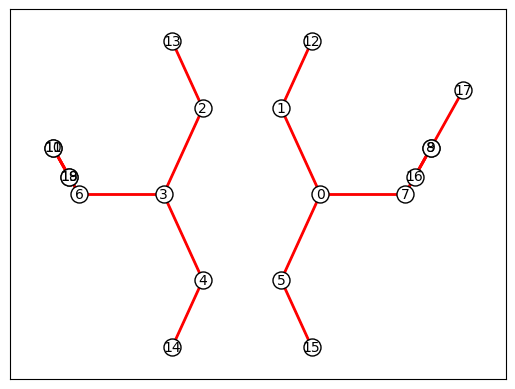

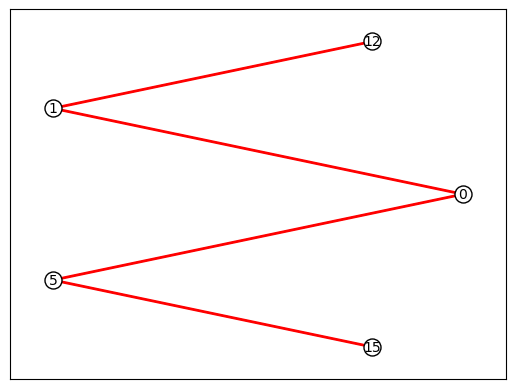

In [10]:
rows = lines_of_single_frag(subgraph_side_frag,Xs_indices)
single_frag_bonds = get_bonds_from_subgraph(subgraph_side_frag,Xs_indices)
#if linker_topic == 3:

create_cif(rows,single_frag_bonds,'edges','tritriedge.cif')


plot2dedge(lG,coords,lG.edges())
plot2dedge(subgraph_side_frag,coords,subgraph_side_frag.edges())


In [11]:
from MOF_builder.ditopic import MOF_ditopic

template = 'rna.cif' #UIO6x #lib file 
node_connection= 6   #lib file 
#linker_topic = 3


#######################################################################
! rm mil/.DS_Store
! rm edges/.DS_Store
#! rm edges/*.cif

templates_dir = "templates"
nodes_dir = 'mil' #default 
edges_dir = 'edges' #default 


new_mof = MOF_ditopic(templates_dir,nodes_dir,edges_dir,template,node_connection)
new_mof.load(True)




rm: cannot remove 'mil/.DS_Store': No such file or directory
rm: cannot remove 'edges/.DS_Store': No such file or directory

template : rna.cif

['tritriedge copy.cif', 'diedge.cif', 'node_sbus_no_ext_conns copy.cif', 'ntn_edge.cif']
Number of vertices =  12
Number of edges =  24

*****************************************************************
RMSD of the compatible node BBs with assigned vertices:          
*****************************************************************

vertex V (6 connected)
     node_sbus_no_ext_conns copy.cif deviation = 0.28736 (within tolerance)
* 1 compatible building blocks out of 1 available for node V *
vertex Er (3 connected)
     tritriedge copy.cif deviation = 0.18982 (within tolerance)
* 1 compatible building blocks out of 1 available for node Er *

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
vertex assignment :  ['v1-node_sbus_no_ext_conns copy.cif', 'v2-tritriedge copy.cif']
+++++++++++++++++++++++++

<class 'networkx.utils.decorators.argmap'> compilation 30:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


scaling unit cell and vertex positions...
optimizing with local minimization algorithm L-BFGS-B...

The final objective function value is 5541.639

*******************************************
The scaled unit cell parameters are : 
*******************************************
a    : 35.91209
b    : 7.66884
c    : 35.67996
alpha: 77.23539
beta : 91.5069
gamma: 102.83173



Exception: Coordinate number/dimension mismatch.